# Region Generation

This notebook performs the segmentation of the updates in the Reddit experiment.

The general idea is to build a graph of updates and learn to compute weights for its edges based on a few hand-engineered features from updates. We later perform a second phase where regions from the first phase are clustered using a new set of features. In both cases these weights are learned using ground truth project/artpiece assignments from the place atlas.

In [ ]:
import csv
import numpy as np
import scipy
import networkx as nx
import math
import sys
import os
import subprocess
import scipy.stats
import scipy.optimize
import operator
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import csr_matrix

sys.path.append("../Python_code") # go to parent dir
from canvas_vis import * 
from analytics_combined import *
from generate_proj_to_remove import *
from project_data_analysis import *
from user_embedding import *
from segmentation import *
from evaluation import *
import pickle

In [ ]:
#Parameters

#Area of the canvas considered (0-1002,0-1002 is the full canvas)
min_x = 0
max_x = 1002
min_y = 0
max_y = 1002

#distance threshold in update graphs
#updates within dist_threshold positions from each other
#that co-exist at any point in time will be connected
dist_threshold = 2

#Multithreading
num_threads = 3

#Kappa parameter for the region segmentation of the
#update graph
KAPPA_updates = 1.

#Kappa parameter for the segmentation of the
#region graph
KAPPA_region = .55

#User signed embedding parameters
ndim=80
threshold=5
total_samples=300
n_negatives=5
n_iterations=10

In [ ]:
input_file= "../data/sorted_tile_placements_proj.csv"
js_filename = "../data/atlas_complete.json"
names, descriptions = read_picture_names_and_descriptions(js_filename)

In [4]:
#Reading ground truth data

t = time.time()

projects_to_remove = get_list_of_removed_proj(output_filename = "../data/proj_to_remove.txt")

pfile = open('projects_to_remove.pkl', 'wb')
pickle.dump(projects_to_remove, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  366.974490404129  seconds


In [ ]:
pfile = open('projects_to_remove.pkl', 'rb')
projects_to_remove = pickle.load(pfile)
pfile.close()

In [ ]:
'''
NOTE: This function saves several pkl files in order to avoid
        recomputation in case of failure.
        However, this also means that these pkl files must be manually deleted
        if you want to regenerate the data structures.
'''

# This super function does everything that the following cells in the notebook do

regions = create_regions(2, 
                    'gboost',
                    num_threads,
                    input_file,
                    projects_to_remove,
                    dist_threshold, 
                    ndim, 
                    threshold, 
                    total_samples, 
                    n_negatives, 
                    n_iterations,
                    min_x, 
                    max_x,
                    min_y,
                    max_y,
                    excluded_folds=[8,9],
                    use_scalar = False,
                    delete_pkl_files = False
                    )

## Part I: Update segmentation.

In [4]:
#Creating and saving update graph and associated list of updates

t = time.time()

G_ups, ups = create_graph(input_file, projects_to_remove, dist_threshold, min_x, max_x, min_y, max_y)

print("num edges = ", G_ups.n_edges)

pfile = open('graph.pkl', 'wb')
pickle.dump(G_ups, pfile)
pfile.close()

pfile = open('ups.pkl', 'wb')
pickle.dump(ups, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

num edges =  468179461
time =  11393.113628149033  seconds


In [4]:
#Reading existing update graph and associated list of updates

pfile = open('graph.pkl', 'rb')
G_ups = pickle.load(pfile)
pfile.close()

pfile = open('ups.pkl', 'rb')
ups = pickle.load(pfile)
pfile.close()

In [5]:
#Functions that compute edge features for the
#update graph. The functions receive indexes
#of a pair of updates and some necessary data
#and return a real value.

def different_color(i, j, ups, data=None):
    '''
        Simply checks if updates have different color.
    '''
    if ups[i][4] == ups[j][4]:
        return 0
    else:
        return 1
        
def distance_space(i, j, ups, data=None):
    '''
        Eclidean distance between updates.
    '''
    xi = ups[i][2]
    yi = ups[i][3]
    xj = ups[j][2]
    yj = ups[j][3]
    
    return np.sqrt(pow(xi-xj,2)+pow(yi-yj,2))

def distance_time(i, j, ups, data=None):
    '''
        Time distance between updates
        in hours.
    '''
    time_i = ups[i][0]
    time_j = ups[j][0]
    
    return np.abs(time_i-time_j) / 3600000 #hours

def distance_duration(i, j, ups, durations):
    '''
        Distance between duration of updates.
        See function dist_duration for details.
    '''
    return dist_duration(durations[i], durations[j])

def distance_color(i, j, ups, conflicts):
    '''
        Computes the distance between two colors
        based on how often one has replaced the
        other in that particular position (x,y).
    '''
    color_i = ups[i][4]
    color_j = ups[j][4]
    
    if color_i == color_j:
        return 0
    else:
        max_up = len(ups)
        dist = 0
        
        conf_i = []
        if conflicts[i][0] <= max_up:
            conf_i.append(ups[conflicts[i][0]][4])
            
        if conflicts[i][1] <= max_up:
            conf_i.append(ups[conflicts[i][1]][4])
        
        conf_j = []
        if conflicts[j][0] <= max_up:
            conf_j.append(ups[conflicts[j][0]][4])
            
        if conflicts[j][1] <= max_up:
            conf_j.append(ups[conflicts[j][1]][4])
        
        if color_i in conf_j:
            dist = dist + 1
            
        if color_j in conf_i:
            dist = dist + 1
        
        return dist
    
def distance_user_embedding(i, j, ups, data):
    '''
        Euclidean distance between user embeddings.
    '''
    user_i = ups[i][1]
    user_j = ups[j][1]
    user_i_id = data['index'][user_i]
    user_j_id = data['index'][user_j]
    
    return np.linalg.norm(data['emb'][user_i_id]-data['emb'][user_j_id])

def distance_user_colors(i, j, ups, data):
    '''
        Distance between user color histograms.
        One minus sum of minimum values for each
        color.
    '''
    user_i = ups[i][1]
    user_j = ups[j][1]
    user_i_id = data['index'][user_i]
    user_j_id = data['index'][user_j]
    
    return 1.-data['emb'][user_i_id].minimum(data['emb'][user_j_id]).sum()

In [ ]:
#Prepares data for feature computation and saves it.
#Takes a long time.

t = time.time()

conflicts = compute_update_conflicts(ups)
durations = compute_update_durations(ups)
user_color, user_index_color = compute_user_color(ups)

user_index, emb = embed_users(G_ups, ups, ndim, threshold, total_samples, n_negatives, n_iterations, True)

features = [{'name': "different_color", 'func': different_color, 'data': None}, 
    {'name': "distance_space",  'func': distance_space, 'data': None}, 
    {'name': "distance_time", 'func': distance_time, 'data': None}, 
    {'name': "distance_color", 'func': distance_color, 'data': conflicts},
    {'name': "distance_user_embedding", 'func': distance_user_embedding, 'data': {'index': user_index, 'emb': emb}},
    {'name': "distance_user_colors", 'func': distance_user_colors, 'data': {'index': user_index_color, 'emb': user_color}}]

pfile = open('features.pkl', 'wb')
pickle.dump(features, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

python ../../signet/signet.py -l signet_id.txt -i signet.txt -o signet -d 80 -t 5 -s 300
balanced:
+++  0.5976795913378369  rand =  0.29385183715605007
+--  0.17136901946737437  rand =  0.22406061290053328
unbalanced:
++-  0.20882472445355368  rand =  0.44443432383806364
---  0.022126664741235123  rand =  0.03765322610535283


In [6]:
#Reading existing feature data

pfile = open('features.pkl', 'rb')
features = pickle.load(pfile)
pfile.close()

In [38]:
#Creating feature matrix A and vector of labels b
#for learning an edge weight model

t = time.time()

A,b = build_feat_label_data(G_ups, ups, features)

print(A.shape)
print(b.sum() / b.shape[0])

print("time = ", time.time()-t, " seconds")

(183160993, 6)
0.132574608830604
time =  169906.55031895638  seconds


In [39]:
#Learning edge weight model using gradient boosting regression
#and saving model.

t = time.time()

model = GradientBoostingRegressor(random_state=1, n_estimators=25).fit(A, b)

pfile = open('model.pkl', 'wb')
pickle.dump(model, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  17630.278561115265  seconds


In [7]:
#Reading an existing edge weight model

pfile = open('model.pkl', 'rb')
model = pickle.load(pfile)
pfile.close()

In [40]:
#Feature importances

for f in range(len(features)):
    print("feature: ", features[f]['name'], model.feature_importances_[f])

feature:  different_color 0.46490553380734306
feature:  distance_space 0.12343094289747825
feature:  distance_time 0.06383471982987886
feature:  distance_color 0.007661969877624684
feature:  distance_user_embedding 0.27313792080206967
feature:  distance_user_colors 0.06702891278560545


In [48]:
#Computing edge weights using multithreading
#and sorting the edges in increasing order.
#Not every edge in the the unique_edges file
#will be included in the new file.

t = time.time()

compute_edge_weights_multithread(G_ups, ups, model, features, 'features.pkl', num_threads)
G_ups.sort_edges()

print("time = ", time.time()-t, " seconds")

In [8]:
#Performing region segmentation on the update graph

t = time.time()

comp_assign, int_weights = region_segmentation(G_ups, ups, 0.8)
regions, sizes, int_weights = extract_regions(comp_assign, int_weights)

pfile = open('up_regions.pkl', 'wb')
pickle.dump([regions, sizes, int_weights], pfile)
pfile.close()

print("num regions = ", len(regions), " max size region = ", np.max(sizes))

print("time = ", time.time()-t, " seconds")

num regions =  1089319  max size region =  21183
time =  4809.032828092575  seconds


In [ ]:
pfile = open('up_regions.pkl', 'rb')
ups_region_info = pickle.load(pfile)
pfile.close()

regions = ups_region_info[0]
sizes = ups_region_info[1]
int_weights = ups_region_info[2]

time =  6924.861782073975  seconds


<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

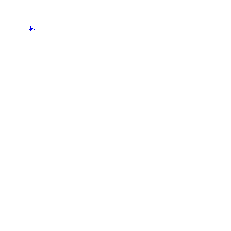

In [27]:
#Drawing top 1000 regions

def draw_region(ups, region, output_file_name):
    '''
        Draws region into file.
    '''
    ups_region = updates_region(ups, region)

    plt.close('all')

    canvas_ups = extract_canvas_updates_region(ups_region)
    canvas_ups_rgb = canvas_color_code_rgb(canvas_ups)

    draw_canvas(canvas_ups_rgb, output_file_name)

def draw_top_regions(ups, regions, sizes, k, output_file_name='../plots/top_region'):
    '''
        Draws top k largest regions
    '''
    ind  = np.argsort(sizes)

    for i in range(1, k+1):
        r = ind[-i]

        draw_region(ups, regions[r], output_file_name+"_"+str(i)+".svg")

t = time.time()

draw_top_regions(ups, regions, sizes, 1000)

print("time = ", time.time()-t, " seconds")

In [28]:
#Distribution of region sizes

size_dist = np.zeros(np.max(sizes)+1)

for r in regions:
    size_dist[len(r)] = size_dist[len(r)] + 1
    
for i in range(size_dist.shape[0]):
    if size_dist[i] > 0:
        print("size = ", i, " number = ", size_dist[i], " % of total updates = ", 100*i*size_dist[i] / len(ups))

size =  1  number =  812106.0  % of total updates =  5.667798287054798
size =  2  number =  113548.0  % of total updates =  1.584933887690765
size =  3  number =  42698.0  % of total updates =  0.8939854572949804
size =  4  number =  22343.0  % of total updates =  0.623739349925578
size =  5  number =  13850.0  % of total updates =  0.4833051736824316
size =  6  number =  10069.0  % of total updates =  0.42163752726137793
size =  7  number =  7031.0  % of total updates =  0.34349214055058824
size =  8  number =  5458.0  % of total updates =  0.304736997886927
size =  9  number =  4355.0  % of total updates =  0.2735472387362152
size =  10  number =  3588.0  % of total updates =  0.25041140262419703
size =  11  number =  2951.0  % of total updates =  0.22654973635964493
size =  12  number =  2524.0  % of total updates =  0.21138407365333556
size =  13  number =  2193.0  % of total updates =  0.19896819056335657
size =  14  number =  1910.0  % of total updates =  0.18662209883419814
size

size =  170  number =  38.0  % of total updates =  0.04508521909008676
size =  171  number =  51.0  % of total updates =  0.060865045771617124
size =  172  number =  38.0  % of total updates =  0.045615633432323076
size =  173  number =  38.0  % of total updates =  0.045880840603441234
size =  174  number =  28.0  % of total updates =  0.0340023509917806
size =  175  number =  35.0  % of total updates =  0.042747208502597736
size =  176  number =  51.0  % of total updates =  0.0626447254725416
size =  177  number =  47.0  % of total updates =  0.0580594330666303
size =  178  number =  38.0  % of total updates =  0.047206876459032016
size =  179  number =  46.0  % of total updates =  0.057466206499655476
size =  180  number =  35.0  % of total updates =  0.043968557316957674
size =  181  number =  31.0  % of total updates =  0.03915993255642056
size =  182  number =  23.0  % of total updates =  0.029214663639489654
size =  183  number =  25.0  % of total updates =  0.03192954757540974
s

size =  380  number =  13.0  % of total updates =  0.03447693224536046
size =  381  number =  8.0  % of total updates =  0.021272406778109047
size =  382  number =  9.0  % of total updates =  0.02399426985011119
size =  383  number =  16.0  % of total updates =  0.04276814591084391
size =  384  number =  7.0  % of total updates =  0.018759917788568607
size =  385  number =  13.0  % of total updates =  0.03493057609069415
size =  386  number =  10.0  % of total updates =  0.026939465276739148
size =  387  number =  15.0  % of total updates =  0.04051388495633957
size =  388  number =  16.0  % of total updates =  0.043326476797408454
size =  389  number =  18.0  % of total updates =  0.04886791084656153
size =  390  number =  17.0  % of total updates =  0.04627167222403641
size =  391  number =  9.0  % of total updates =  0.024559579872757788
size =  392  number =  10.0  % of total updates =  0.027358213441662553
size =  393  number =  14.0  % of total updates =  0.03839920672347637
size

size =  590  number =  6.0  % of total updates =  0.02470614173048098
size =  591  number =  7.0  % of total updates =  0.028872685971468873
size =  592  number =  5.0  % of total updates =  0.02065824280288805
size =  593  number =  7.0  % of total updates =  0.028970393876617668
size =  594  number =  7.0  % of total updates =  0.029019247829192064
size =  595  number =  6.0  % of total updates =  0.02491551581294268
size =  596  number =  9.0  % of total updates =  0.037436085944152535
size =  597  number =  4.0  % of total updates =  0.016666176963951576
size =  598  number =  5.0  % of total updates =  0.020867616885349754
size =  599  number =  9.0  % of total updates =  0.037624522618368066
size =  600  number =  14.0  % of total updates =  0.0586247430892769
size =  601  number =  11.0  % of total updates =  0.04613906863847733
size =  602  number =  5.0  % of total updates =  0.02100719960699089
size =  603  number =  11.0  % of total updates =  0.04629260963228258
size =  604

size =  800  number =  5.0  % of total updates =  0.027916544328227096
size =  801  number =  6.0  % of total updates =  0.033541728010364855
size =  802  number =  8.0  % of total updates =  0.04477813710247626
size =  803  number =  6.0  % of total updates =  0.033625477643349534
size =  804  number =  3.0  % of total updates =  0.01683367622992094
size =  805  number =  8.0  % of total updates =  0.044945636368445625
size =  806  number =  8.0  % of total updates =  0.045001469457102074
size =  807  number =  8.0  % of total updates =  0.04505730254575853
size =  808  number =  3.0  % of total updates =  0.01691742586290562
size =  809  number =  5.0  % of total updates =  0.02823060545191965
size =  810  number =  2.0  % of total updates =  0.011306200452931974
size =  811  number =  5.0  % of total updates =  0.028300396812740217
size =  812  number =  7.0  % of total updates =  0.0396694094904107
size =  813  number =  3.0  % of total updates =  0.01702211290413647
size =  814  n

size =  1011  number =  5.0  % of total updates =  0.03527953289479699
size =  1013  number =  2.0  % of total updates =  0.014139729702247023
size =  1014  number =  2.0  % of total updates =  0.014153687974411137
size =  1015  number =  2.0  % of total updates =  0.01416764624657525
size =  1016  number =  4.0  % of total updates =  0.02836320903747873
size =  1017  number =  5.0  % of total updates =  0.03548890697725869
size =  1018  number =  2.0  % of total updates =  0.014209521063067592
size =  1019  number =  2.0  % of total updates =  0.014223479335231704
size =  1021  number =  5.0  % of total updates =  0.03562848969889983
size =  1023  number =  1.0  % of total updates =  0.00713965621194408
size =  1024  number =  3.0  % of total updates =  0.02143990604407841
size =  1025  number =  2.0  % of total updates =  0.014307228968216385
size =  1026  number =  2.0  % of total updates =  0.0143211872403805
size =  1027  number =  9.0  % of total updates =  0.06450815480645077
si

size =  1236  number =  4.0  % of total updates =  0.03450484878968869
size =  1237  number =  2.0  % of total updates =  0.01726638266700846
size =  1238  number =  1.0  % of total updates =  0.008640170469586286
size =  1239  number =  1.0  % of total updates =  0.008647149605668343
size =  1241  number =  2.0  % of total updates =  0.01732221575566491
size =  1243  number =  2.0  % of total updates =  0.01735013229999314
size =  1244  number =  3.0  % of total updates =  0.02604613585823588
size =  1245  number =  3.0  % of total updates =  0.02606707326648205
size =  1246  number =  2.0  % of total updates =  0.01739200711648548
size =  1248  number =  3.0  % of total updates =  0.02612988549122056
size =  1249  number =  4.0  % of total updates =  0.034867763865955644
size =  1251  number =  1.0  % of total updates =  0.008730899238653025
size =  1252  number =  4.0  % of total updates =  0.03495151349894032
size =  1253  number =  1.0  % of total updates =  0.008744857510817137
s

size =  1485  number =  1.0  % of total updates =  0.01036401708185431
size =  1486  number =  3.0  % of total updates =  0.0311129886538091
size =  1487  number =  2.0  % of total updates =  0.020755950708036847
size =  1488  number =  2.0  % of total updates =  0.02076990898020096
size =  1489  number =  1.0  % of total updates =  0.010391933626182535
size =  1490  number =  2.0  % of total updates =  0.020797825524529186
size =  1491  number =  1.0  % of total updates =  0.01040589189834665
size =  1492  number =  2.0  % of total updates =  0.020825742068857414
size =  1493  number =  3.0  % of total updates =  0.03125955051153229
size =  1494  number =  1.0  % of total updates =  0.01042682930659282
size =  1495  number =  3.0  % of total updates =  0.03130142532802463
size =  1496  number =  1.0  % of total updates =  0.010440787578756933
size =  1497  number =  3.0  % of total updates =  0.03134330014451697
size =  1498  number =  2.0  % of total updates =  0.020909491701842094
s

size =  1753  number =  2.0  % of total updates =  0.02446885110369105
size =  1754  number =  2.0  % of total updates =  0.02448280937585516
size =  1755  number =  2.0  % of total updates =  0.024496767648019276
size =  1757  number =  1.0  % of total updates =  0.012262342096173752
size =  1758  number =  1.0  % of total updates =  0.012269321232255808
size =  1759  number =  1.0  % of total updates =  0.012276300368337866
size =  1761  number =  2.0  % of total updates =  0.024580517281003956
size =  1762  number =  3.0  % of total updates =  0.03689171332975211
size =  1763  number =  3.0  % of total updates =  0.03691265073799828
size =  1765  number =  1.0  % of total updates =  0.012318175184830206
size =  1766  number =  1.0  % of total updates =  0.012325154320912262
size =  1767  number =  1.0  % of total updates =  0.01233213345699432
size =  1768  number =  1.0  % of total updates =  0.012339112593076376
size =  1770  number =  1.0  % of total updates =  0.0123530708652404

size =  1973  number =  1.0  % of total updates =  0.013769835489898014
size =  1974  number =  2.0  % of total updates =  0.027553629251960143
size =  1978  number =  3.0  % of total updates =  0.041414193510924895
size =  1979  number =  1.0  % of total updates =  0.013811710306390355
size =  1983  number =  1.0  % of total updates =  0.013839626850718583
size =  1984  number =  1.0  % of total updates =  0.01384660598680064
size =  1985  number =  2.0  % of total updates =  0.02770717024576539
size =  1988  number =  1.0  % of total updates =  0.013874522531128867
size =  1989  number =  1.0  % of total updates =  0.013881501667210923
size =  1992  number =  1.0  % of total updates =  0.013902439075457093
size =  1993  number =  1.0  % of total updates =  0.01390941821153915
size =  1995  number =  1.0  % of total updates =  0.013923376483703264
size =  1996  number =  1.0  % of total updates =  0.01393035561978532
size =  1997  number =  2.0  % of total updates =  0.027874669511734

size =  2280  number =  1.0  % of total updates =  0.015912430267089443
size =  2284  number =  2.0  % of total updates =  0.03188069362283534
size =  2286  number =  3.0  % of total updates =  0.047862915250745354
size =  2287  number =  1.0  % of total updates =  0.015961284219663842
size =  2290  number =  1.0  % of total updates =  0.015982221627910013
size =  2292  number =  1.0  % of total updates =  0.015996179900074126
size =  2293  number =  2.0  % of total updates =  0.03200631807231236
size =  2295  number =  1.0  % of total updates =  0.016017117308320297
size =  2296  number =  1.0  % of total updates =  0.016024096444402353
size =  2297  number =  1.0  % of total updates =  0.01603107558048441
size =  2299  number =  1.0  % of total updates =  0.01604503385264852
size =  2300  number =  1.0  % of total updates =  0.01605201298873058
size =  2301  number =  2.0  % of total updates =  0.032117984249625274
size =  2302  number =  1.0  % of total updates =  0.0160659712608946

size =  2702  number =  1.0  % of total updates =  0.018857625693717402
size =  2706  number =  1.0  % of total updates =  0.01888554223804563
size =  2708  number =  1.0  % of total updates =  0.018899500510209742
size =  2711  number =  1.0  % of total updates =  0.018920437918455914
size =  2712  number =  1.0  % of total updates =  0.01892741705453797
size =  2715  number =  2.0  % of total updates =  0.03789670892556828
size =  2718  number =  2.0  % of total updates =  0.03793858374206062
size =  2720  number =  1.0  % of total updates =  0.018983250143194425
size =  2721  number =  3.0  % of total updates =  0.056970687837829444
size =  2725  number =  1.0  % of total updates =  0.01901814582360471
size =  2730  number =  2.0  % of total updates =  0.038106083008029985
size =  2733  number =  2.0  % of total updates =  0.03814795782452233
size =  2735  number =  1.0  % of total updates =  0.019087937184425276
size =  2737  number =  1.0  % of total updates =  0.01910189545658939

size =  3314  number =  1.0  % of total updates =  0.023128856975936148
size =  3316  number =  1.0  % of total updates =  0.023142815248100263
size =  3321  number =  2.0  % of total updates =  0.046355421857021094
size =  3323  number =  2.0  % of total updates =  0.04638333840134932
size =  3326  number =  2.0  % of total updates =  0.04642521321784166
size =  3334  number =  2.0  % of total updates =  0.046536879395154565
size =  3337  number =  1.0  % of total updates =  0.023289377105823454
size =  3338  number =  2.0  % of total updates =  0.04659271248381102
size =  3342  number =  2.0  % of total updates =  0.046648545572467476
size =  3343  number =  1.0  % of total updates =  0.023331251922315794
size =  3348  number =  1.0  % of total updates =  0.023366147602726078
size =  3349  number =  2.0  % of total updates =  0.04674625347761627
size =  3354  number =  1.0  % of total updates =  0.023408022419218417
size =  3355  number =  1.0  % of total updates =  0.023415001555300

size =  4214  number =  1.0  % of total updates =  0.029410079449787244
size =  4215  number =  1.0  % of total updates =  0.0294170585858693
size =  4225  number =  1.0  % of total updates =  0.029486849946689868
size =  4229  number =  1.0  % of total updates =  0.029514766491018096
size =  4236  number =  2.0  % of total updates =  0.05912724088718499
size =  4237  number =  2.0  % of total updates =  0.0591411991593491
size =  4238  number =  1.0  % of total updates =  0.029577578715756607
size =  4256  number =  2.0  % of total updates =  0.05940640633046726
size =  4259  number =  1.0  % of total updates =  0.029724140573479798
size =  4260  number =  1.0  % of total updates =  0.029731119709561857
size =  4267  number =  1.0  % of total updates =  0.029779973662136253
size =  4269  number =  1.0  % of total updates =  0.029793931934300365
size =  4272  number =  1.0  % of total updates =  0.029814869342546537
size =  4273  number =  1.0  % of total updates =  0.02982184847862859

size =  6411  number =  1.0  % of total updates =  0.044743241422065975
size =  6420  number =  1.0  % of total updates =  0.04480605364680449
size =  6460  number =  1.0  % of total updates =  0.04508521909008676
size =  6480  number =  1.0  % of total updates =  0.045224801811727895
size =  6515  number =  1.0  % of total updates =  0.04546907157459988
size =  6534  number =  1.0  % of total updates =  0.04560167516015896
size =  6559  number =  1.0  % of total updates =  0.04577615356221038
size =  6563  number =  1.0  % of total updates =  0.04580407010653861
size =  6597  number =  1.0  % of total updates =  0.04604136073332853
size =  6612  number =  1.0  % of total updates =  0.04614604777455939
size =  6679  number =  1.0  % of total updates =  0.04661364989205719
size =  6709  number =  1.0  % of total updates =  0.046823023974518894
size =  6722  number =  1.0  % of total updates =  0.046913752743585634
size =  6750  number =  1.0  % of total updates =  0.047109168553883224
s

In [29]:
#Printing top regions sizes

ind  = np.argsort(sizes)
k=20

for i in range(1, k):
    r = ind[-i]
    print("region: ", r, " size = ", len(regions[r]))

region:  1378  size =  21183
region:  444440  size =  20420
region:  1195  size =  19316
region:  75558  size =  15642
region:  186  size =  15358
region:  15674  size =  14994
region:  257314  size =  12682
region:  45438  size =  12641
region:  481452  size =  12377
region:  184  size =  12097
region:  31572  size =  11660
region:  723  size =  11003
region:  9007  size =  10945
region:  941  size =  10600
region:  11963  size =  10535
region:  3779  size =  10252
region:  934198  size =  10138
region:  80987  size =  9829
region:  7608  size =  9695


In [550]:
#Creating a folder with figures for producing
#bash convert_svg_png.sh region_video
#ffmpeg -framerate 1 -i region_video/%d.png -vcodec mjpeg video.avi

create_region_video(ups, regions[ind[-1]], "../plots/region_video")

## Part II: Region clustering

In [31]:
def build_region_graph(G, regions, ups, label_threshold, projects_to_remove, name='reg'):
    '''
        Builds graph of adjacent regions
    '''
    comp_assign = []

    for u in ups:
        comp_assign.append(0)

    region_labels = []
    n_labelled = 0
    for r in range(len(regions)):
        for u in regions[r]:
            comp_assign[u] = r

        lb, ratio = region_label(regions[r], ups, projects_to_remove)

        #If region membership is above threshold
        #assign region to project
        if ratio >= label_threshold:
            region_labels.append(int(lb))
            n_labelled = n_labelled + 1
        else:
            region_labels.append(0)

    print("#labelled regions = ", n_labelled)
    print("#unlabelled regions = ", len(regions)-n_labelled)

    G_reg = MyGraph(name)
    G_reg.clear()

    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = r[2]
            type_edge = int(r[3])

            reg_u = comp_assign[u]
            reg_v = comp_assign[v]

            if reg_u != reg_v and type_edge > 0:
                G_reg.add_edge(reg_u, reg_v, 0, 1)

    G_reg.flush_edges()
    G_reg.remove_repeated_edges()

    true_edges = 0
    false_edges = 0
    unlabelled_edges = 0
    
    with open(G_reg.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            reg_u = int(r[0])
            reg_v = int(r[1])
            lb = r[2]
            type_edge = int(r[3])

            lb_u = region_labels[reg_u]
            lb_v = region_labels[reg_v]

            #add_edge(self, node1, node2, label, type_edge)
            if lb_u > 0 or lb_v > 0:
                if lb_u == lb_v:
                    G_reg.add_edge(reg_u, reg_v, 1, 1)
                    false_edges = false_edges + 1
                else:
                    G_reg.add_edge(reg_u, reg_v, 0, 1)
                    true_edges = true_edges + 1
            else:
                G_reg.add_edge(reg_u, reg_v, 2, 1)
                unlabelled_edges = unlabelled_edges + 1

    G_reg.flush_edges()
    G_reg.remove_repeated_edges()

    print("#true edges = ", true_edges)
    print("#false edges = ", false_edges)
    print("#unlabelled edges = ", unlabelled_edges)

    return G_reg


In [11]:
#Building region graph and saving it

t = time.time()

G_reg = build_region_graph(G_ups, regions, ups, .5, projects_to_remove)

pfile = open('reg_graph.pkl', 'wb')
pickle.dump(G_reg, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

#labelled regions =  188905
#unlabelled regions =  900414
#true edges =  2873905
#false edges =  373364
#unlabelled edges =  2590750
time =  3183.8621933460236  seconds


In [ ]:
pfile = open('reg_graph.pkl', 'rb')
G_reg = pickle.load(pfile)
pfile.close()

In [12]:
#Functions that compute edge features for the
#region graph. The functions receive indexes
#of a pair of regions and some necessary data
#and return a real value.

def difference_internal_weights(i, j, ups, data):
    '''
        Internal weights measure the diversity of
        of the edges in a region. This computes
        their difference.
    '''
    return np.abs(data[i]-data[j])
    
def sum_internal_weights(i, j, ups, data):
    '''
        Internal weights measure the diversity of
        of the edges in a region. This computes
        their sum.
    '''
    return data[i]+data[j]
    
def distance_region_user_embedding(i, j, ups, data):
    '''
        Distance between avg user embeddings for regions.
    '''
    return np.linalg.norm(data[i]-data[j])

def distance_region_user_colors(i, j, ups, data):
    '''
        Distance between avg user color embeddings for regions.
    '''
    return 1.-np.minimum(data[i], data[j]).sum()
    
def distance_region_durations(i, j, ups, data):
    '''
        Distance between the durations of two regions.
    '''
    return dist_duration(data[i], data[j])

def distance_users_per_region(i, j, ups, data):
    '''
        Distance between user participations between regions.
        It is weighted by user activity.
    '''
    sz = min(len(data['regions'][i]), len(data['regions'][j]))
    dist = sz
    for u in data['users'][i]:
        if u in data['users'][j]:
            dist = dist - min(data['users'][i][u], data['users'][j][u])
            
    return dist / sz

def superposition(i,j, ups, data):
    '''
        Superposition between two regions, which is a 
        normalized count of the number of updates in 
        the same position but with different colors
        in the final version of the region (as there
        can be layers).
    '''
    pos_i = {}
    for ui in data[i]:
        up = ups[ui]
        x = up[2]
        y = up[3]
        t = up[0]
        c = up[4]
        
        if (x,y) not in pos_i:
            pos_i[(x,y)] = (c,t)
        elif pos_i[(x,y)][1] < t:
            pos_i[(x,y)] = (c,t)
    
    pos_j = {}
    for uj in data[j]:
        up = ups[uj]
        x = up[2]
        y = up[3]
        t = up[0]
        c = up[4]
        
        if (x,y) not in pos_j:
            pos_j[(x,y)] = (c,t)
        elif pos_j[(x,y)][1] < t:
            pos_j[(x,y)] = (c,t)
    
    count = 0
    for (x,y) in pos_i:
        if (x,y) in pos_j:
            if pos_i[(x,y)][0] != pos_j[(x,y)][0]:
                count = count + 1
                
    return count / min(len(pos_i), len(pos_j))
    
def avg_update_time_distance(i,j,ups,data):
    '''
        Computes (absolute) distance between the
        average time of two regions.
    '''
    avg_ti = 0
    for ui in data[i]:
        upi = ups[ui]
        avg_ti = avg_ti + upi[0]
    
    avg_ti = avg_ti / len(data[i])
    
    avg_tj = 0
    for uj in data[j]:
        upj = ups[uj]
        avg_tj = avg_tj + upj[0]      
    
    avg_tj = avg_tj / len(data[j])
    
    return np.abs(avg_ti-avg_tj) / 3600000 #hours

def avg_update_pos_distance(i,j,ups,data):
    '''
        Computes the distance between the average
        points of two regions.
    '''
    avg_xi = 0
    avg_yi = 0
    
    for ui in data[i]:
        upi = ups[ui]
        xi = upi[2]
        yi = upi[3]
        
        avg_xi = avg_xi + xi
        avg_yi = avg_yi + yi
        
    avg_xi = avg_xi / len(data[i])
    avg_yi = avg_yi / len(data[i])
    
    avg_xj = 0
    avg_yj = 0
            
    for uj in data[j]:
        upj = ups[uj]
        xj = upj[2]
        yj = upj[3]
        
        avg_xj = avg_xj + xj
        avg_yj = avg_yj + yj
        
    avg_xj = avg_xj / len(data[j])
    avg_yj = avg_yj / len(data[j])
    
    return math.sqrt(math.pow(avg_xi-avg_xj,2)+math.pow(avg_yi-avg_yj,2))

def sizes(i, j, ups, data):
    '''
    '''
    return len(data[i])+len(data[j])

def bounding_box_distance(i, j, ups, data):
    '''
        Amount of empty space in the bounding box
        of the combined region.
    '''
    min_xi = data[i][0]
    max_xi = data[i][1]
    min_yi = data[i][2]
    max_yi = data[i][3]

    min_xj = data[j][0]
    max_xj = data[j][1]
    min_yj = data[j][2]
    max_yj = data[j][3]
    
    joint_area = (max(max_xi, max_xj)-min(min_xi, min_xj)+1) * (max(max_yi, max_yj)-min(min_yi, min_yj)+1)
    inters_area = (min(max_xi, max_xj)-max(min_xi, min_xj)+1) * (min(max_yi, max_yj)-max(min_yi, min_yj)+1)
    inters_area = max(0,inters_area)
    
    area_i = (max_xi-min_xi+1) * (max_yi-min_yi+1)
    area_j = (max_xj-min_xj+1) * (max_yj-min_yj+1)
    
    return (joint_area - area_i - area_j + inters_area) / joint_area

def distance_region_colors(i, j, ups, data):
    '''
        Distance between distributions of user colors
        in the regions.
    '''
    return 1.-data[i].minimum(data[j]).sum()

In [13]:
def compute_region_colors(regions, ups):
    '''
        Computes sparse matrix of color frequencies
        for each region.
    '''
    rows = []
    cols = []
    data = []
    for r in range(len(regions)):
        region = regions[r]
        colors = np.zeros(16)
        for u in region:
            up = ups[u]
            color = int(up[4])
            colors[color] = colors[color] + 1

        colors = colors / np.sum(colors)

        for c in range(len(colors)):
            if colors[c] > 0:
                rows.append(r)
                cols.append(c)
                data.append(colors[c])

    return scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(regions), 16))


In [14]:
#Prepares data for feature computation and saves it.

t = time.time()

durations = compute_update_durations(ups)
region_durations = compute_region_durations(regions, durations, ups)
users_per_region = compute_users_per_region(regions, ups)

emb = features[4]['data']['emb']
user_index = features[4]['data']['index']

region_sign_emb = compute_user_vector_regions(regions, emb, user_index, ups)

user_color = features[5]['data']['emb']
user_index_color = features[5]['data']['index']

region_colors_emb = compute_user_vector_regions(regions, user_color, user_index_color, ups)

region_colors = compute_region_colors(regions, ups)

bounding_boxes = compute_region_bounding_boxes(regions, ups)

region_features = [{'name': "distance_user_embedding", 'func': distance_region_user_embedding, 'data': region_sign_emb},
    {'name': "users_per_region", 'func': distance_users_per_region, 'data':{'users': users_per_region, 'regions':regions}}, 
    {'name': "superposition", 'func': superposition, 'data':regions},
    {'name': "pos_distance", 'func': avg_update_pos_distance, 'data':regions},
    {'name': "sizes", 'func': sizes, 'data':regions},
    {'name': "bounding_box", 'func': bounding_box_distance, 'data':bounding_boxes},
    {'name': "dist_region_color", 'func': distance_region_colors, 'data':region_colors},
    {'name': 'avg_update_distance', 'func': avg_update_pos_distance, 'data':regions},
    {'name': 'dist_user_colors', 'func': distance_region_user_colors, 'data':region_colors_emb},
    {'name': 'dist_region_durations', 'func': distance_region_durations, 'data':region_durations},
    {'name': 'diff_internal_weight', 'func': difference_internal_weights, 'data':int_weights},
    {'name': 'sum_internal_weight', 'func': sum_internal_weights, 'data':int_weights}
]

pfile = open('features_regions.pkl', 'wb')
pickle.dump(region_features, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  4582.876185894012  seconds


In [ ]:
#Reading existing feature data

pfile = open('features_regions.pkl', 'rb')
region_features = pickle.load(pfile)
pfile.close()

In [51]:
def region_neighborhood(region, G, ups, features, regions):
    '''
        Prints neighborhood information (edges and feature values)
        for a given region.
    '''
    with open(G.sorted_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = int(r[2])
            type_edge = int(r[3])

            if (u == region or v == region) and len(regions[u]) > 50 and len(regions[v]) > 50:
                print(u, ",", v, ",",lb)
                print("size_u=", len(regions[u])," size_v=", len(regions[v]))
                for f in range(len(features)):
                    print(features[f]['name'], " ", features[f]['func'](u, v, ups, features[f]['data']))

                print()

In [52]:
#Neighborhood information for a particular region

region_neighborhood(1, G_reg, ups, region_features, regions)

1 , 14 , 2
size_u= 176  size_v= 383
distance_user_embedding   0.24679469180064392
users_per_region   0.9829545454545454
superposition   0.0
pos_distance   687.899874889637
sizes   559
bounding_box   1.7711627294146826
dist_region_color   0.36207868502254925
avg_update_distance   687.899874889637
dist_user_colors   0.18539472535317936
dist_region_durations   0.4175079568529746
diff_internal_weight   0.11756367974648455
sum_internal_weight   0.3394303395803492

1 , 4 , 2
size_u= 176  size_v= 4461
distance_user_embedding   0.24790373895548123
users_per_region   0.9715909090909091
superposition   0.125
pos_distance   49.31667961194127
sizes   4637
bounding_box   0.0
dist_region_color   0.3291557131503332
avg_update_distance   49.31667961194127
dist_user_colors   0.16059676655502453
dist_region_durations   0.5877960325993321
diff_internal_weight   0.13246046085689023
sum_internal_weight   0.32453355846994353

1 , 12 , 2
size_u= 176  size_v= 146
distance_user_embedding   0.155611977833952
us

In [15]:
def build_feat_label_regions(G, ups, features):
    ''' 
        Extracts feature values and labels for edges between regions.

        features is a dictionary with both functions that compute
        feature values and the data structures they require, used as:

        A[i,f] = features[f]['func'](u, v, ups, features[f]['data'])

        Returns matrix A with feature values and vector b with labels
    '''
    #Counting labelled points
    n_labelled = 0
    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = int(r[2])
            type_edge = int(r[3])

            if lb in [0,1]:
                n_labelled = n_labelled + 1

    A = np.zeros((n_labelled+1, len(features)))
    b = np.zeros(n_labelled+1)

    i = 0
    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = int(r[2])
            type_edge = int(r[3])

            if lb in [0,1]:
                for f in range(len(features)):
                    A[i,f] = features[f]['func'](u, v, ups, features[f]['data'])

                    if lb == 1:
                        b[i] = float(0.)
                    else:
                        b[i] = float(1.)

                i = i + 1
                   
    return A, b

In [19]:
#Creating feature matrix A and vector of labels b
#for learning an region edge weight model

t = time.time()

A, b = build_feat_label_regions(G_reg, ups, region_features)

print(A.shape)
print(b.sum() / b.shape[0])

print("time = ", time.time()-t, " seconds")

(3247270, 12)
0.8850218799175923
time =  17987.92038846016  seconds


In [20]:
#Learning region edge weight model using gradient boosting regression
#and saving model.

t = time.time()

model = GradientBoostingRegressor(random_state=1, n_estimators=25).fit(A, b)

pfile = open('model_regions.pkl', 'wb')
pickle.dump(model, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  460.0019006729126  seconds


In [ ]:
#Reading an existing region edge weight model

pfile = open('model_regions.pkl', 'rb')
model = pickle.load(pfile)
pfile.close()

In [21]:
#Feature importances

for f in range(len(region_features)):
    print("feature: ", region_features[f]['name'], model.feature_importances_[f])

feature:  distance_user_embedding 0.5296815988879147
feature:  users_per_region 0.026492131219845817
feature:  superposition 0.0
feature:  pos_distance 0.030350293414686865
feature:  sizes 0.0025254481260113845
feature:  bounding_box 0.0016970949171643756
feature:  dist_region_color 0.2580637466043664
feature:  avg_update_distance 0.02594965967391786
feature:  dist_user_colors 0.0718123217076994
feature:  dist_region_durations 0.022191116369143345
feature:  diff_internal_weight 0.018028563189783874
feature:  sum_internal_weight 0.013208025889465852


In [22]:
#Computing region edge weights using multithreading
#and sorting the edges in increasing order.

t = time.time()

compute_edge_weights_multithread(G_reg, ups, model, region_features, 'features_regions.pkl', num_threads)
G_reg.sort_edges()

print("time = ", time.time()-t, " seconds")

time =  9171.836487531662  seconds


In [27]:
#Performing segmentation on the region graph

t = time.time()

comp_assign_reg, int_weights_reg = region_segmentation(G_reg, regions, 0.55)
reg_regions, reg_sizes, super_int_weights = extract_regions(comp_assign_reg, int_weights_reg)
super_regions, super_region_sizes, super_region_assign = extract_super_region_info(reg_regions, regions)

pfile = open('super_regions.pkl', 'wb')
pickle.dump([super_regions, super_region_sizes, super_region_assign], pfile)
pfile.close()

print("num regions = ", len(super_regions), " max size region = ", np.max(super_region_sizes))

print("time = ", time.time()-t, " seconds")

num regions =  1034080  max size region =  231210
time =  65.45499014854431  seconds


time =  731.5784964561462  seconds


<Figure size 432x288 with 0 Axes>

<Figure size 7200x7200 with 0 Axes>

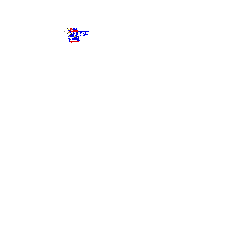

In [28]:
#Drawing top 1000 regions

t = time.time()

draw_top_regions(ups, super_regions, super_region_sizes, 100)

print("time = ", time.time()-t, " seconds")

In [29]:
#Distribution of region sizes

size_dist = np.zeros(np.max(super_region_sizes)+1)

for r in super_regions:
    size_dist[len(r)] = size_dist[len(r)] + 1
    
for i in range(size_dist.shape[0]):
    if size_dist[i] > 0:
        print("size = ", i, " number = ", size_dist[i], " % of total updates = ", 100*i*size_dist[i] / len(ups))

size =  1  number =  793990.0  % of total updates =  5.5413642577922575
size =  2  number =  106163.0  % of total updates =  1.4818520477587867
size =  3  number =  38153.0  % of total updates =  0.7988249368161363
size =  4  number =  19492.0  % of total updates =  0.5441492820458025
size =  5  number =  11973.0  % of total updates =  0.4178059815523288
size =  6  number =  8569.0  % of total updates =  0.358825302522867
size =  7  number =  5963.0  % of total updates =  0.2913161192011318
size =  8  number =  4556.0  % of total updates =  0.2543755519188053
size =  9  number =  3644.0  % of total updates =  0.22888774694713396
size =  10  number =  3031.0  % of total updates =  0.2115376146471408
size =  11  number =  2462.0  % of total updates =  0.18900896337426154
size =  12  number =  2090.0  % of total updates =  0.17503673293798389
size =  13  number =  1821.0  % of total updates =  0.16521708847053002
size =  14  number =  1574.0  % of total updates =  0.15379224270420305
size

size =  225  number =  17.0  % of total updates =  0.02669519551386716
size =  226  number =  13.0  % of total updates =  0.0205047018090828
size =  227  number =  9.0  % of total updates =  0.014258375015641988
size =  228  number =  15.0  % of total updates =  0.023868645400634166
size =  229  number =  13.0  % of total updates =  0.020776888116283015
size =  230  number =  17.0  % of total updates =  0.027288422080841986
size =  231  number =  21.0  % of total updates =  0.03385578913405741
size =  232  number =  14.0  % of total updates =  0.0226682339945204
size =  233  number =  13.0  % of total updates =  0.021139803192549968
size =  234  number =  17.0  % of total updates =  0.027763003334421846
size =  235  number =  14.0  % of total updates =  0.022961357709966785
size =  236  number =  15.0  % of total updates =  0.02470614173048098
size =  237  number =  10.0  % of total updates =  0.016540552514474553
size =  238  number =  13.0  % of total updates =  0.021593447037883656


size =  513  number =  3.0  % of total updates =  0.010740890430285375
size =  514  number =  5.0  % of total updates =  0.01793637973088591
size =  515  number =  3.0  % of total updates =  0.010782765246777716
size =  516  number =  6.0  % of total updates =  0.021607405310047772
size =  517  number =  2.0  % of total updates =  0.007216426708846704
size =  518  number =  2.0  % of total updates =  0.007230384981010818
size =  519  number =  4.0  % of total updates =  0.014488686506349862
size =  520  number =  1.0  % of total updates =  0.0036291507626695224
size =  521  number =  2.0  % of total updates =  0.007272259797503159
size =  522  number =  6.0  % of total updates =  0.021858654209001814
size =  523  number =  7.0  % of total updates =  0.025550617196409848
size =  524  number =  7.0  % of total updates =  0.025599471148984247
size =  525  number =  2.0  % of total updates =  0.007328092886159612
size =  526  number =  3.0  % of total updates =  0.011013076737485588
size =

size =  797  number =  1.0  % of total updates =  0.005562371457399249
size =  798  number =  2.0  % of total updates =  0.011138701186962611
size =  799  number =  2.0  % of total updates =  0.011152659459126725
size =  800  number =  1.0  % of total updates =  0.0055833088656454186
size =  801  number =  3.0  % of total updates =  0.016770864005182427
size =  803  number =  4.0  % of total updates =  0.022416985095566357
size =  805  number =  3.0  % of total updates =  0.016854613638167107
size =  806  number =  3.0  % of total updates =  0.01687555104641328
size =  807  number =  3.0  % of total updates =  0.01689648845465945
size =  808  number =  1.0  % of total updates =  0.005639141954301873
size =  809  number =  2.0  % of total updates =  0.01129224218076786
size =  810  number =  1.0  % of total updates =  0.005653100226465987
size =  812  number =  2.0  % of total updates =  0.0113341169972602
size =  813  number =  1.0  % of total updates =  0.005674037634712157
size =  81

size =  1062  number =  2.0  % of total updates =  0.014823685038288587
size =  1063  number =  1.0  % of total updates =  0.0074188216552263505
size =  1065  number =  1.0  % of total updates =  0.007432779927390464
size =  1066  number =  2.0  % of total updates =  0.01487951812694504
size =  1067  number =  1.0  % of total updates =  0.007446738199554577
size =  1069  number =  3.0  % of total updates =  0.022382089415156074
size =  1070  number =  1.0  % of total updates =  0.007467675607800748
size =  1071  number =  1.0  % of total updates =  0.007474654743882805
size =  1072  number =  1.0  % of total updates =  0.007481633879964861
size =  1073  number =  2.0  % of total updates =  0.014977226032093836
size =  1074  number =  4.0  % of total updates =  0.0299823686085159
size =  1076  number =  2.0  % of total updates =  0.015019100848586178
size =  1077  number =  1.0  % of total updates =  0.007516529560375146
size =  1079  number =  3.0  % of total updates =  0.0225914634976

size =  1563  number =  1.0  % of total updates =  0.010908389696254737
size =  1566  number =  2.0  % of total updates =  0.021858654209001814
size =  1568  number =  1.0  % of total updates =  0.01094328537666502
size =  1569  number =  1.0  % of total updates =  0.010950264512747079
size =  1570  number =  1.0  % of total updates =  0.010957243648829135
size =  1573  number =  1.0  % of total updates =  0.010978181057075305
size =  1574  number =  1.0  % of total updates =  0.010985160193157362
size =  1576  number =  1.0  % of total updates =  0.010999118465321476
size =  1577  number =  1.0  % of total updates =  0.011006097601403532
size =  1580  number =  1.0  % of total updates =  0.011027035009649702
size =  1590  number =  1.0  % of total updates =  0.01109682637047027
size =  1593  number =  2.0  % of total updates =  0.022235527557432883
size =  1601  number =  2.0  % of total updates =  0.02234719373474579
size =  1602  number =  1.0  % of total updates =  0.01118057600345

size =  2132  number =  2.0  % of total updates =  0.02975903625389008
size =  2134  number =  1.0  % of total updates =  0.014893476399109155
size =  2136  number =  1.0  % of total updates =  0.014907434671273269
size =  2138  number =  1.0  % of total updates =  0.014921392943437382
size =  2139  number =  2.0  % of total updates =  0.029856744159038877
size =  2144  number =  1.0  % of total updates =  0.014963267759929722
size =  2145  number =  1.0  % of total updates =  0.01497024689601178
size =  2147  number =  1.0  % of total updates =  0.014984205168175894
size =  2152  number =  2.0  % of total updates =  0.030038201697172355
size =  2153  number =  1.0  % of total updates =  0.015026079984668234
size =  2155  number =  1.0  % of total updates =  0.015040038256832347
size =  2159  number =  1.0  % of total updates =  0.015067954801160575
size =  2164  number =  2.0  % of total updates =  0.030205700963141718
size =  2168  number =  1.0  % of total updates =  0.0151307670258

size =  3029  number =  1.0  % of total updates =  0.021139803192549968
size =  3030  number =  1.0  % of total updates =  0.021146782328632024
size =  3031  number =  2.0  % of total updates =  0.04230752292942816
size =  3047  number =  1.0  % of total updates =  0.02126542764202699
size =  3058  number =  1.0  % of total updates =  0.021342198138929614
size =  3062  number =  1.0  % of total updates =  0.021370114683257842
size =  3071  number =  1.0  % of total updates =  0.021432926907996353
size =  3081  number =  1.0  % of total updates =  0.02150271826881692
size =  3085  number =  1.0  % of total updates =  0.02153063481314515
size =  3096  number =  1.0  % of total updates =  0.021607405310047772
size =  3098  number =  1.0  % of total updates =  0.021621363582211884
size =  3101  number =  1.0  % of total updates =  0.021642300990458056
size =  3115  number =  1.0  % of total updates =  0.02174000889560685
size =  3130  number =  1.0  % of total updates =  0.0218446959368377

size =  4801  number =  1.0  % of total updates =  0.03350683232995457
size =  4830  number =  1.0  % of total updates =  0.033709227276334214
size =  4835  number =  1.0  % of total updates =  0.033744122956744504
size =  4850  number =  1.0  % of total updates =  0.033848809997975356
size =  4857  number =  1.0  % of total updates =  0.03389766395054975
size =  4863  number =  1.0  % of total updates =  0.03393953876704209
size =  4870  number =  1.0  % of total updates =  0.03398839271961649
size =  4872  number =  1.0  % of total updates =  0.0340023509917806
size =  4874  number =  1.0  % of total updates =  0.034016309263944715
size =  4878  number =  1.0  % of total updates =  0.03404422580827294
size =  4882  number =  1.0  % of total updates =  0.03407214235260117
size =  4888  number =  1.0  % of total updates =  0.03411401716909351
size =  4914  number =  1.0  % of total updates =  0.034295474707226985
size =  4921  number =  2.0  % of total updates =  0.06868865731960276
si

size =  9099  number =  1.0  % of total updates =  0.06350315921063458
size =  9106  number =  1.0  % of total updates =  0.06355201316320898
size =  9144  number =  1.0  % of total updates =  0.06381722033432714
size =  9192  number =  1.0  % of total updates =  0.06415221886626586
size =  9276  number =  1.0  % of total updates =  0.06473846629715864
size =  9296  number =  1.0  % of total updates =  0.06487804901879977
size =  9333  number =  1.0  % of total updates =  0.06513627705383587
size =  9337  number =  1.0  % of total updates =  0.0651641935981641
size =  9353  number =  1.0  % of total updates =  0.06527585977547701
size =  9432  number =  1.0  % of total updates =  0.0658272115259595
size =  9447  number =  1.0  % of total updates =  0.06593189856719034
size =  9471  number =  1.0  % of total updates =  0.0660993978331597
size =  9490  number =  1.0  % of total updates =  0.06623200141871878
size =  9495  number =  1.0  % of total updates =  0.06626689709912907
size =  9

size =  30557  number =  1.0  % of total updates =  0.21326146125940884
size =  30733  number =  1.0  % of total updates =  0.21448978920985082
size =  31264  number =  1.0  % of total updates =  0.218195710469423
size =  31375  number =  1.0  % of total updates =  0.21897039457453127
size =  31784  number =  1.0  % of total updates =  0.2218248612320925
size =  32014  number =  1.0  % of total updates =  0.22343006253096556
size =  32329  number =  1.0  % of total updates =  0.22562849039681343
size =  32358  number =  1.0  % of total updates =  0.2258308853431931
size =  32438  number =  1.0  % of total updates =  0.22638921622975763
size =  32913  number =  1.0  % of total updates =  0.22970430586873458
size =  33015  number =  1.0  % of total updates =  0.2304161777491044
size =  34032  number =  1.0  % of total updates =  0.2375139591445561
size =  34225  number =  1.0  % of total updates =  0.23886093240839307
size =  34270  number =  1.0  % of total updates =  0.2391749935320856

In [30]:
#Printing top regions

ind  = np.argsort(super_region_sizes)
k=20

for i in range(1, k):
    r = ind[-i]
    print("region: ", r, " size = ", len(super_regions[r]))

region:  166  size =  231210
region:  829  size =  198562
region:  169  size =  178243
region:  17  size =  159897
region:  33  size =  133989
region:  1677  size =  129036
region:  1392  size =  124099
region:  1099  size =  121064
region:  514  size =  98927
region:  7844  size =  97129
region:  226406  size =  95067
region:  523  size =  86855
region:  687  size =  84966
region:  95  size =  77793
region:  1661  size =  76452
region:  3920  size =  70580
region:  134561  size =  62549
region:  464  size =  60945
region:  3358  size =  58698


## Part 3: Region Clustering Again

In [32]:
#Building region graph and saving it

t = time.time()

G_reg_2 = build_region_graph(G_ups, super_regions, ups, .5, projects_to_remove, 'reg_2')

pfile = open('reg_2_graph.pkl', 'wb')
pickle.dump(G_reg, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

#labelled regions =  159745
#unlabelled regions =  874335
#true edges =  1228016
#false edges =  106327
#unlabelled edges =  2029608
time =  1752.8275015354156  seconds


In [33]:
#Prepares data for feature computation and saves it.

t = time.time()

super_region_durations = compute_region_durations(super_regions, durations, ups)
users_per_super_region = compute_users_per_region(super_regions, ups)

emb = features[4]['data']['emb']
user_index = features[4]['data']['index']

super_region_sign_emb = compute_user_vector_regions(super_regions, emb, user_index, ups)

user_color = features[5]['data']['emb']
user_index_color = features[5]['data']['index']

super_region_colors_emb = compute_user_vector_regions(super_regions, user_color, user_index_color, ups)

super_region_colors = compute_region_colors(super_regions, ups)

super_bounding_boxes = compute_region_bounding_boxes(super_regions, ups)

super_region_features = [{'name': "distance_user_embedding", 'func': distance_region_user_embedding, 'data': super_region_sign_emb},
    {'name': "users_per_region", 'func': distance_users_per_region, 'data':{'users': users_per_super_region, 'regions':super_regions}}, 
    {'name': "superposition", 'func': superposition, 'data':super_regions},
    {'name': "pos_distance", 'func': avg_update_pos_distance, 'data':super_regions},
    {'name': "sizes", 'func': sizes, 'data':super_regions},
    {'name': "bounding_box", 'func': bounding_box_distance, 'data':super_bounding_boxes},
    {'name': "dist_region_color", 'func': distance_region_colors, 'data':super_region_colors},
    {'name': 'avg_update_distance', 'func': avg_update_pos_distance, 'data':super_regions},
    {'name': 'dist_user_colors', 'func': distance_region_user_colors, 'data':super_region_colors_emb},
    {'name': 'dist_region_durations', 'func': distance_region_durations, 'data':super_region_durations},
    {'name': 'diff_internal_weight', 'func': difference_internal_weights, 'data':super_int_weights},
    {'name': 'sum_internal_weight', 'func': sum_internal_weights, 'data':super_int_weights}
]

pfile = open('features_super_regions.pkl', 'wb')
pickle.dump(super_region_features, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  3890.8604097366333  seconds


In [ ]:
#Reading existing feature data

pfile = open('features_super_regions.pkl', 'rb')
super_region_features = pickle.load(pfile)
pfile.close()

In [ ]:
#Creating feature matrix A and vector of labels b
#for learning an region edge weight model

t = time.time()

A, b = build_feat_label_regions(G_reg_2, ups, super_region_features)

print(A.shape)
print(b.sum() / b.shape[0])

print("time = ", time.time()-t, " seconds")

In [ ]:
#Learning region edge weight model using gradient boosting regression
#and saving model.

t = time.time()

model = GradientBoostingRegressor(random_state=1, n_estimators=25).fit(A, b)

pfile = open('model_super_regions.pkl', 'wb')
pickle.dump(model, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")